The following Analysis and Forecast is performed to analyse the current damage, behaviour, and evolution of Coronavirus (Covid-19), and forecast the future infected and fatality count.

ABOUT THE VIRUS:
Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.

HOW IT SPREADS:
Coronavirus disease spreads primarily through contact with an infected person when they cough or sneeze. It also spreads when a person touches a surface or object that has the virus on it, then touches their eyes, nose, or mouth.


For more information on the virus please visit https://www.who.int/emergencies/diseases/novel-coronavirus-2019

In [100]:
import pandas as pd 
import numpy as np 

import random
import math
import time
import datetime
import operator 

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn')
%matplotlib inline

Fetching the updated COVID-19 data from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series. The data contains the number of confirmed, expired (dead), and recovered cases, location and date wise.

In [101]:
infected_ds = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
fatalities_ds = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_ds = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [102]:
fatalities_ds.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,0,0,1,1,1,2,4,4,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2,2,2,4,5,5,6,8,10,10
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,11,15,17,17,19,21,25,26,29,31
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,0,0,1,1,1,1,3,3,3,6
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,3,4,4,4,6,8,9,13,18,19
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,3
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,0,0,...,6,6,6,6,7,7,7,7,8,8


Fetching column names from one of the datsets

In [103]:
columns = infected_ds.keys()

Getting the date columns from every dataset. 

In [104]:
infected = infected_ds.loc[:, columns[4]:columns[-1]]
fatalities = fatalities_ds.loc[:, columns[4]:columns[-1]]
recovered = recovered_ds.loc[:, columns[4]:columns[-1]]

In [105]:
datelist = infected.keys()

global_count = []
china_count = []
italy_count = []
spain_count = []
india_count = []

total_active = []
total_recovered = []
total_fatalities = []

mortality_rate = []
recovery_rate = []

In [106]:
for x in datelist:
    infected_sum = infected[x].sum()
    fatalities_sum = fatalities[x].sum()
    recovered_sum = recovered[x].sum()
    
    # infetected, fatalities, recovered, and active cases overall
    global_count.append(infected_sum)
    total_fatalities.append(fatalities_sum)
    total_recovered.append(recovered_sum)
    total_active.append(infected_sum-fatalities_sum-recovered_sum)
    
    # calculating mortality and recoery rate overall.
    mortality_rate.append(fatalities_sum/infected_sum)
    recovery_rate.append(recovered_sum/infected_sum)

    # storing infected count country wise (China, Italy, Spain, India)
    china_count.append(infected_ds[infected_ds['Country/Region']=='China'][x].sum())
    italy_count.append(infected_ds[infected_ds['Country/Region']=='Italy'][x].sum())
    spain_count.append(infected_ds[infected_ds['Country/Region']=='Spain'][x].sum())
    india_count.append(infected_ds[infected_ds['Country/Region']=='India'][x].sum())

Increases every day:

In [107]:
def increase(ds):
    d = [] 
    for i in range(len(ds)):
        if i == 0:
            d.append(ds[0])
        else:
            d.append(ds[i]-ds[i-1])
    return d 

globalDailyInc = increase(global_count)
chinaDailyInc = increase(china_count)
italyDailyInc = increase(italy_count)
indiaDailyInc = increase(india_count)
spainDailyInc = increase(spain_count)

In [108]:
daysSince22Jan = np.array([i for i in range(len(datelist))]).reshape(-1, 1)
global_count = np.array(global_count).reshape(-1, 1)
total_fatalities = np.array(total_fatalities).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Forecasting for the next 15 days

In [109]:
futureDays = 15
forecast = np.array([i for i in range(len(datelist)+futureDays)]).reshape(-1, 1)
alteredDates = forecast[:-15]

PERFORMING ANALYSIS AND VISUALISATION:

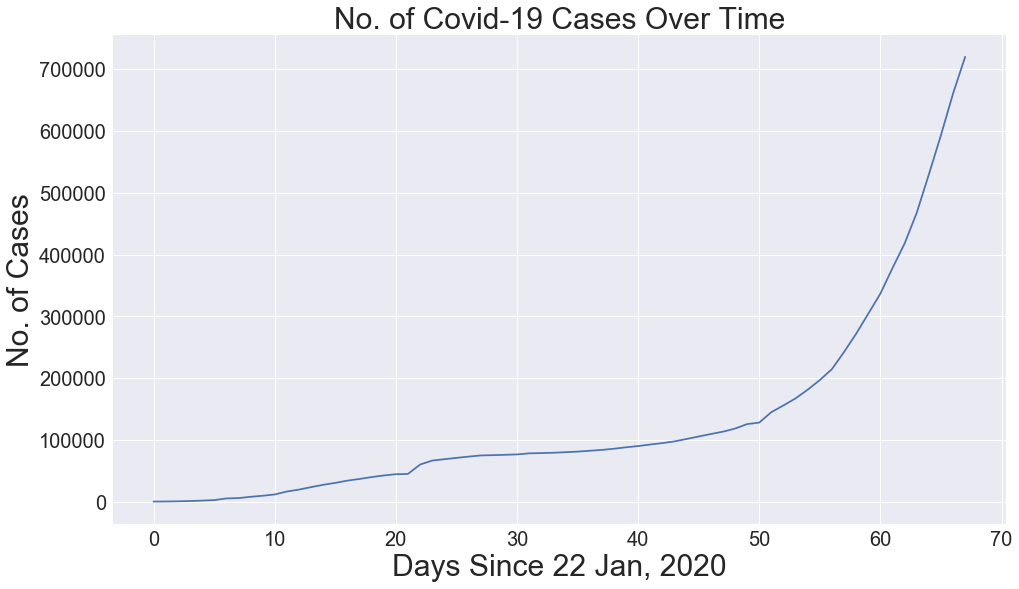

In [110]:
# Number of Covid-19 cases over time
alteredDates = alteredDates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(alteredDates, global_count)
plt.title('No. of Covid-19 Cases Over Time', size=30)
plt.xlabel('Days Since 22 Jan, 2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

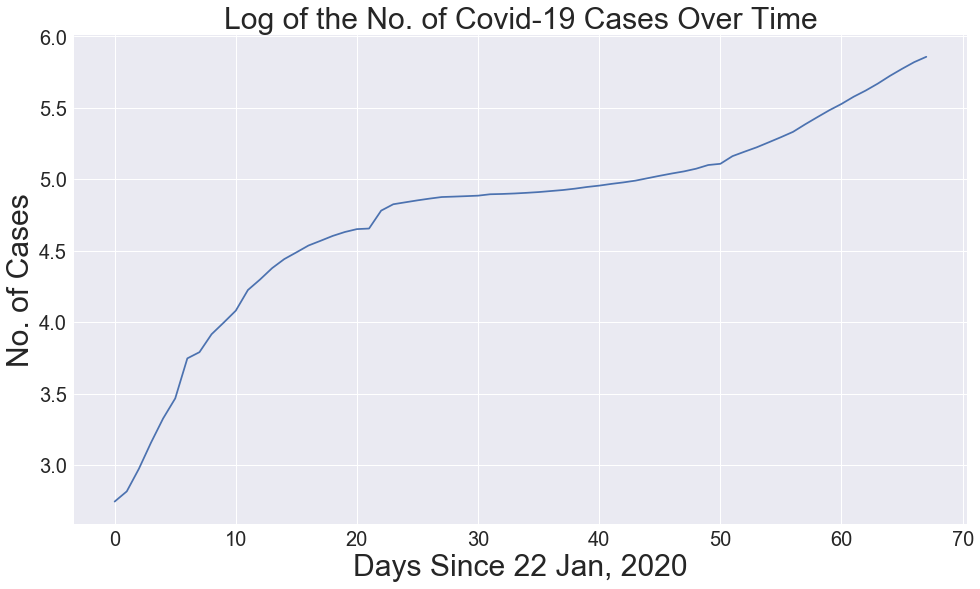

In [111]:
#Log of the No. of Covid-19 Cases Over Time
plt.figure(figsize=(16, 9))
plt.plot(alteredDates, np.log10(global_count))
plt.title('Log of the No. of Covid-19 Cases Over Time', size=30)
plt.xlabel('Days Since 22 Jan, 2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

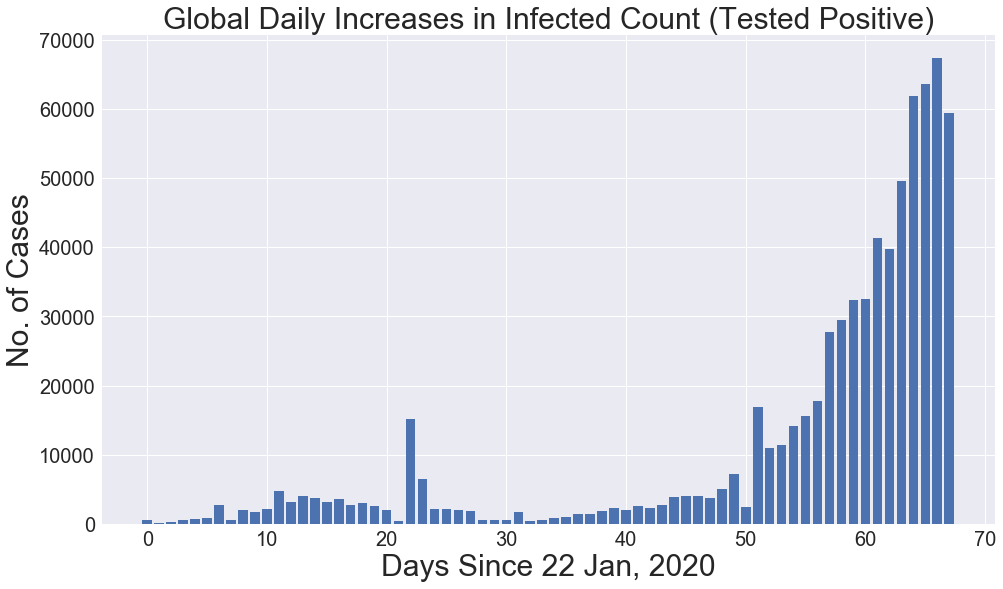

In [112]:
# Global Daily Increases in Infected Count (Tested Positive)
plt.figure(figsize=(16, 9))
plt.bar(alteredDates, globalDailyInc)
plt.title('Global Daily Increases in Infected Count (Tested Positive)', size=30)
plt.xlabel('Days Since 22 Jan, 2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

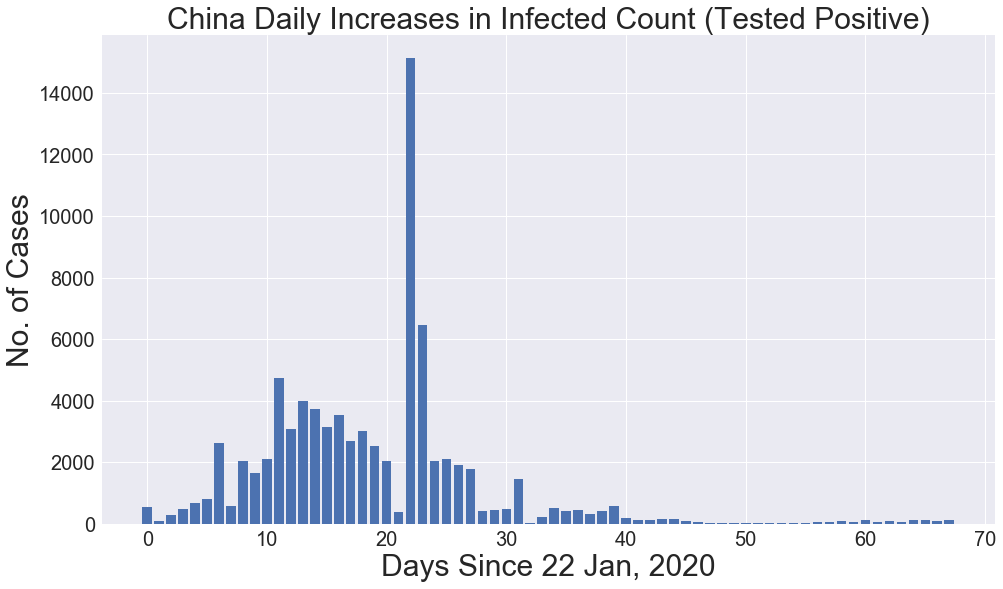

In [113]:
# China Daily Increases in Infected Count (Tested Positive)
plt.figure(figsize=(16, 9))
plt.bar(alteredDates, chinaDailyInc)
plt.title('China Daily Increases in Infected Count (Tested Positive)', size=30)
plt.xlabel('Days Since 22 Jan, 2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

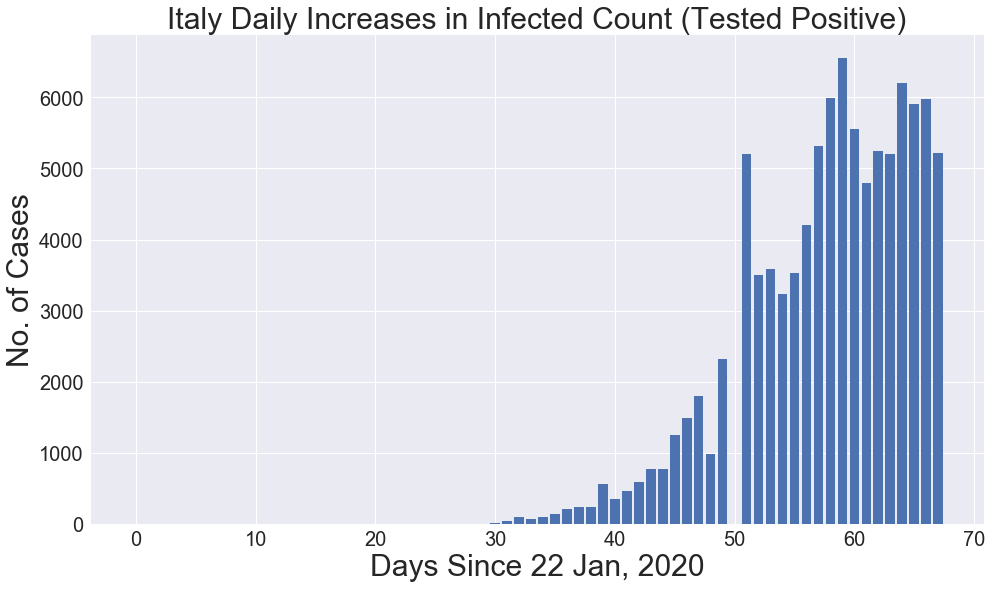

In [114]:
# Italy Daily Increases in Infected Count (Tested Positive)
plt.figure(figsize=(16, 9))
plt.bar(alteredDates, italyDailyInc)
plt.title('Italy Daily Increases in Infected Count (Tested Positive)', size=30)
plt.xlabel('Days Since 22 Jan, 2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

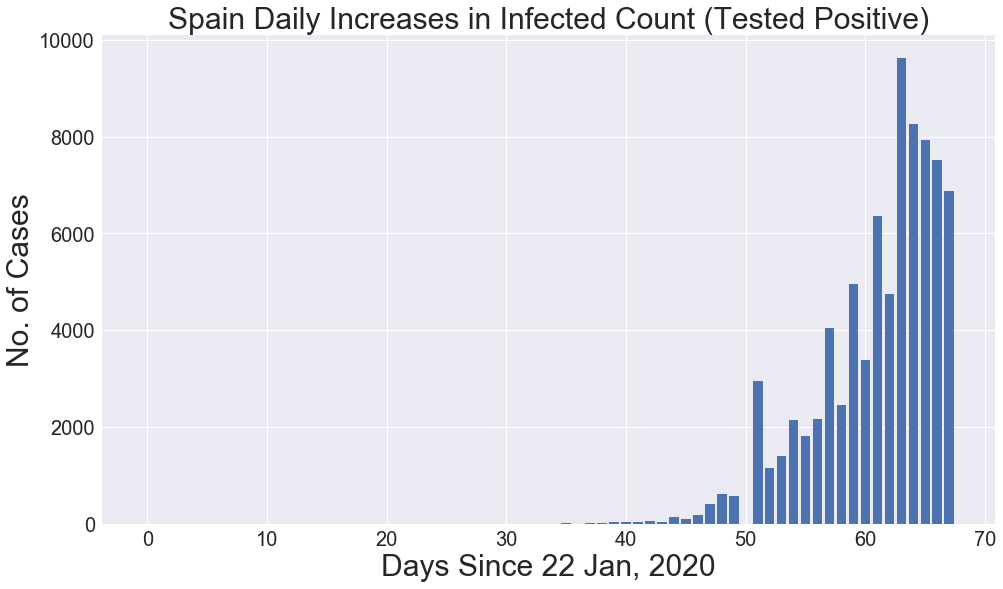

In [115]:
# Spain Daily Increases in Infected Count (Tested Positive)
plt.figure(figsize=(16, 9))
plt.bar(alteredDates, spainDailyInc)
plt.title('Spain Daily Increases in Infected Count (Tested Positive)', size=30)
plt.xlabel('Days Since 22 Jan, 2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

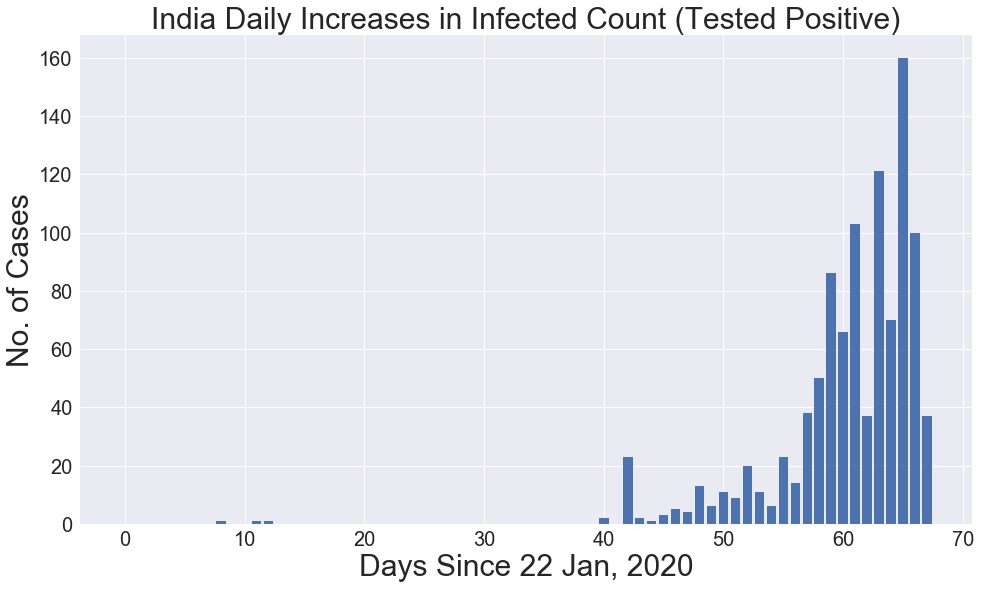

In [116]:
# India Daily Increases in Infected Count (Tested Positive)
plt.figure(figsize=(16, 9))
plt.bar(alteredDates, indiaDailyInc)
plt.title('India Daily Increases in Infected Count (Tested Positive)', size=30)
plt.xlabel('Days Since 22 Jan, 2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

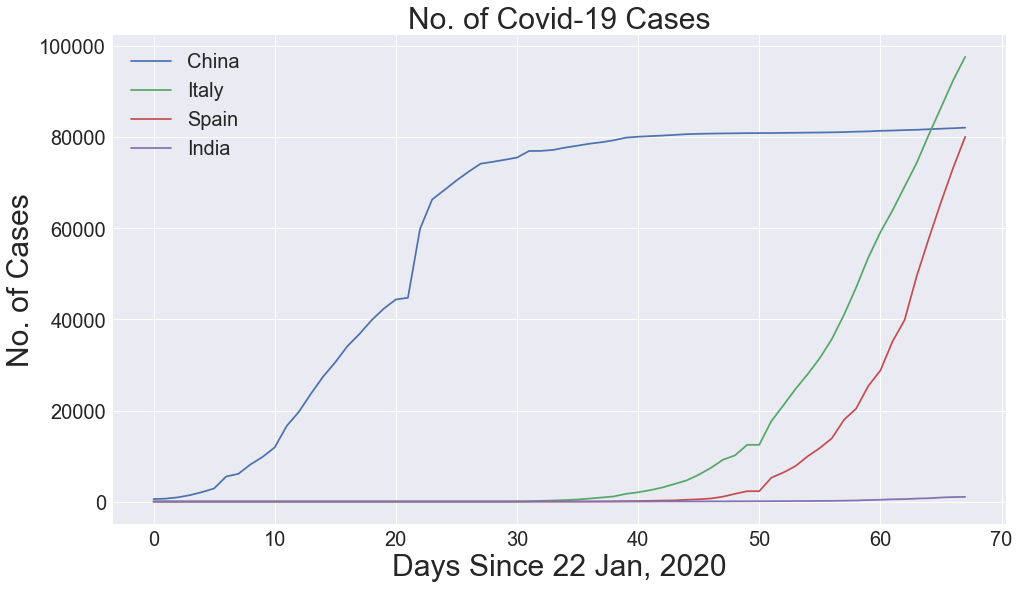

In [117]:
# Comparison between countries
plt.figure(figsize=(16, 9))
plt.plot(alteredDates, china_count)
plt.plot(alteredDates, italy_count)
plt.plot(alteredDates, spain_count)
plt.plot(alteredDates, india_count)
plt.title('No. of Covid-19 Cases', size=30)
plt.xlabel('Days Since 22 Jan, 2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.legend(['China', 'Italy', 'Spain', 'India'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Conclusion: According to the analysis, the number of confirmed (tested positive) cases in Italy and Spain are 
proportionally increasing rapidly, the global count is mostly influenced by Italy and Spain after China, and the China's count has almost stopped increasing. Relatively, India's Daily increase is quite low and sustained.

*******************

FORECAST USING MULTIPLE ALGORITHMS:

In [118]:
begin = '1/22/2020'
initDate = datetime.datetime.strptime(begin, '%m/%d/%Y')
forecastDates = []

for i in range(len(forecast)):
    forecastDates.append((initDate + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [119]:
XTrainInfected, XTestInfected, yTrainInfected, yTestInfected = train_test_split(daysSince22Jan, global_count, test_size=0.15, 
                                                                                shuffle=False)

Employing Linear Regression, Support Vector Machine, and Bayesian Ridge for the forecoast.

In [120]:
# Linear Regression

In [121]:
# Transforming Data
plyReg = PolynomialFeatures(degree=5)
plyRegXTrainInfected = plyReg.fit_transform(XTrainInfected)
plyRegXTestInfected = plyReg.fit_transform(XTestInfected)
plyRegForecast = plyReg.fit_transform(forecast)

In [122]:
# Training
lrModel = LinearRegression(normalize=True, fit_intercept=False)
lrModel.fit(plyRegXTrainInfected, yTrainInfected)
lrFdatesPredict = lrModel.predict(plyRegForecast)

MAE: 48396.60899530949
MSE: 3459028782.098579
Coefficients: [[ 2.95222290e+03 -1.98503857e+03  3.97584922e+02 -9.67067282e+00
   7.73925531e-03  1.26982247e-03]]


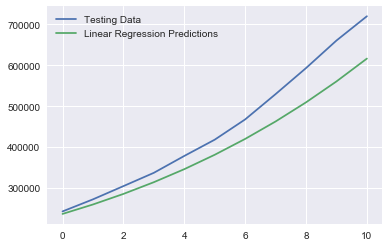

In [123]:
# Testing
lrTestPredict = lrModel.predict(plyRegXTestInfected)
plt.plot(yTestInfected)
plt.plot(lrTestPredict)
plt.legend(['Testing Data', 'Linear Regression Predictions'])
print('MAE:', mean_absolute_error(lrTestPredict, yTestInfected))
print('MSE:',mean_squared_error(lrTestPredict, yTestInfected))
print('Coefficients:',lrModel.coef_)

In [124]:
# Support Vector Machine

In [125]:
# Training
svmInfected = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svmInfected.fit(XTrainInfected, yTrainInfected)
svmFdatesPredict = svmInfected.predict(forecast)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 89174.57972454182
MSE: 11839110158.316637


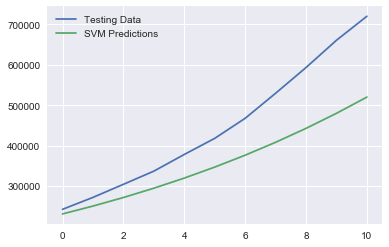

In [126]:
# Testing
svmTestPredict = svmInfected.predict(XTestInfected)
plt.plot(yTestInfected)
plt.plot(svmTestPredict)
plt.legend(['Testing Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svmTestPredict, yTestInfected))
print('MSE:',mean_squared_error(svmTestPredict, yTestInfected))

In [127]:
# Bayesian Ridge Polynomial Regression

In [128]:
# Training
# Searching for the optimal parameters to use for the Baysian Ridge Forecast using RandomizedSearchCV 
# and Training the model.
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesGrid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayes = BayesianRidge(fit_intercept=False, normalize=True)
bayesSearch = RandomizedSearchCV(bayes, bayesGrid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesSearch.fit(plyRegXTrainInfected, yTrainInfected)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=False, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=40, n_jobs=-1,
          param_distributions={'tol': [0.0001, 0.001, 0.01], 'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001], 'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001], 'lambda_1': [1e-07, 1e-06, 1e-05, 0.0001], 'lambda_2': [1e-07, 1e-06, 1e-05, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=1)

In [129]:
# The optimal parameters
bayesSearch.best_params_

{'alpha_1': 1e-06,
 'alpha_2': 0.0001,
 'lambda_1': 1e-07,
 'lambda_2': 0.0001,
 'tol': 0.01}

In [130]:
bayesInfected = bayesSearch.best_estimator_
bayesFdatesPredict = bayesInfected.predict(plyRegForecast)

MAE: 25726.283651085865
MSE: 970727040.7165427


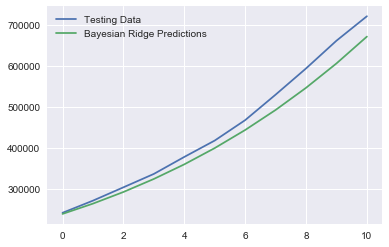

In [131]:
# Testing
bayesTestPredict = bayesInfected.predict(plyRegXTestInfected)
plt.plot(yTestInfected)
plt.plot(bayesTestPredict)
plt.legend(['Testing Data', 'Bayesian Ridge Predictions'])
print('MAE:', mean_absolute_error(bayesTestPredict, yTestInfected))
print('MSE:',mean_squared_error(bayesTestPredict, yTestInfected))

**************
FORECASTING FOR THE NEXT 15 DAYS USING ALL THE ALGORITHMS:
**************

In [132]:
# Forecast using Linear Regression 
lrFdatesPredict = lrFdatesPredict.reshape(1,-1)[0]
print('Linear regression future predictions:')
set(zip(forecastDates[-15:], np.round(lrFdatesPredict[-15:])))

Linear regression future predictions:


{('03/30/2020', 677347.0),
 ('03/31/2020', 743452.0),
 ('04/01/2020', 815135.0),
 ('04/02/2020', 892718.0),
 ('04/03/2020', 976536.0),
 ('04/04/2020', 1066932.0),
 ('04/05/2020', 1164264.0),
 ('04/06/2020', 1268898.0),
 ('04/07/2020', 1381212.0),
 ('04/08/2020', 1501598.0),
 ('04/09/2020', 1630457.0),
 ('04/10/2020', 1768203.0),
 ('04/11/2020', 1915262.0),
 ('04/12/2020', 2072073.0),
 ('04/13/2020', 2239087.0)}

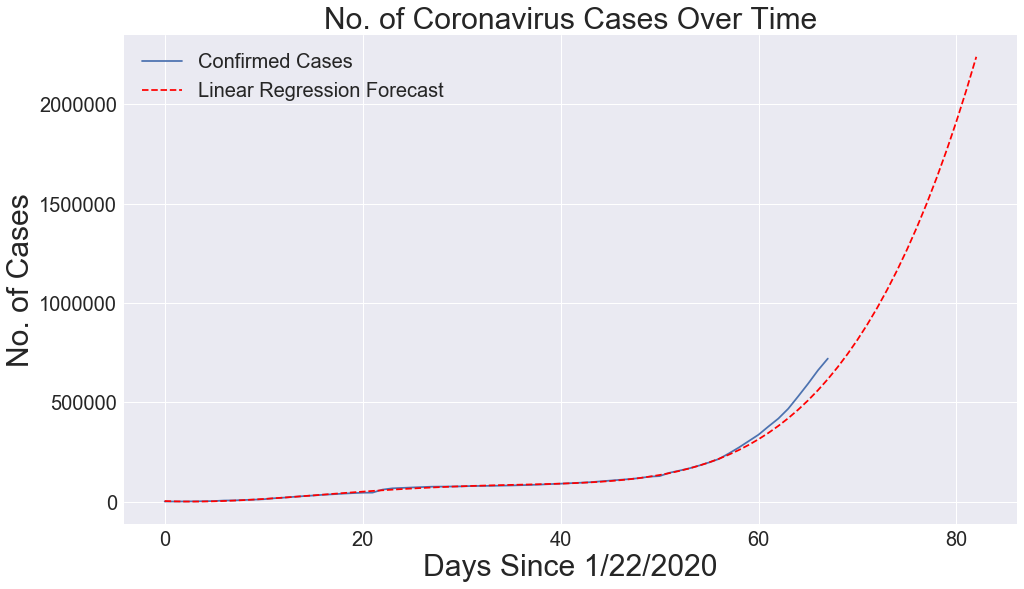

In [133]:
# Linear Regression Forecast Plot
plt.figure(figsize=(16, 9))
plt.plot(alteredDates, global_count)
plt.plot(forecast, lrFdatesPredict, linestyle='dashed', color='red')
plt.title('No. of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.legend(['Confirmed Cases', 'Linear Regression Forecast'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [134]:
# Forecast using SVM
print('SVM future predictions:')
set(zip(forecastDates[-15:], np.round(svmFdatesPredict[-15:])))

SVM future predictions:


{('03/30/2020', 563445.0),
 ('03/31/2020', 610021.0),
 ('04/01/2020', 660098.0),
 ('04/02/2020', 713882.0),
 ('04/03/2020', 771591.0),
 ('04/04/2020', 833448.0),
 ('04/05/2020', 899691.0),
 ('04/06/2020', 970565.0),
 ('04/07/2020', 1046324.0),
 ('04/08/2020', 1127235.0),
 ('04/09/2020', 1213573.0),
 ('04/10/2020', 1305627.0),
 ('04/11/2020', 1403696.0),
 ('04/12/2020', 1508089.0),
 ('04/13/2020', 1619129.0)}

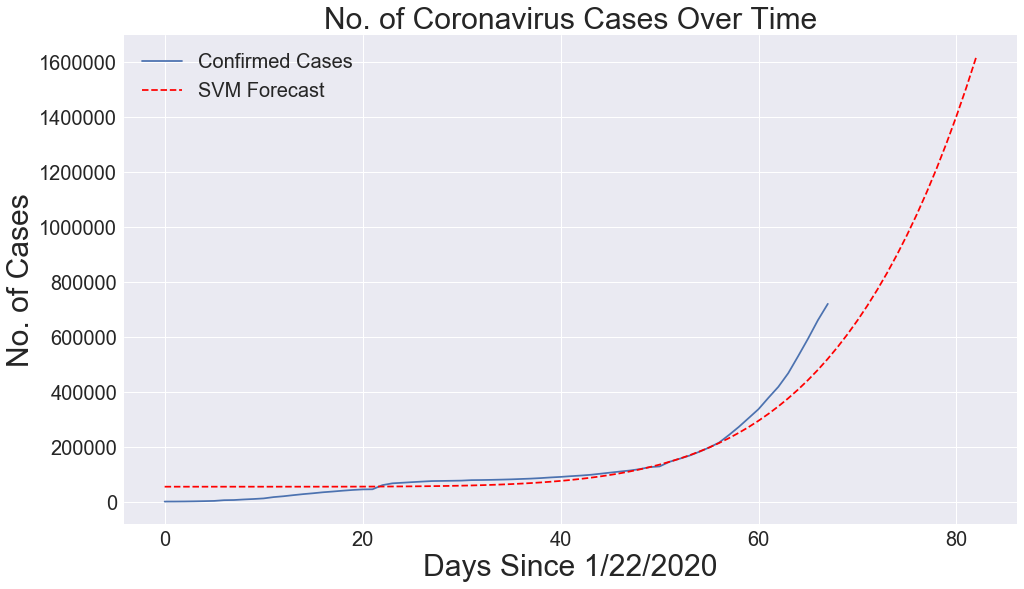

In [135]:
# SVM Forecast Plot
plt.figure(figsize=(16, 9))
plt.plot(alteredDates, global_count)
plt.plot(forecast, svmFdatesPredict, linestyle='dashed', color='red')
plt.title('No. of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM Forecast'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [136]:
# Forecast using Bayesian Ridge 
print('Bayesian Ridge future predictions:')
set(zip(forecastDates[-15:], np.round(bayesFdatesPredict[-15:])))

Bayesian Ridge future predictions:


{('03/30/2020', 742085.0),
 ('03/31/2020', 820236.0),
 ('04/01/2020', 905535.0),
 ('04/02/2020', 998443.0),
 ('04/03/2020', 1099437.0),
 ('04/04/2020', 1209015.0),
 ('04/05/2020', 1327691.0),
 ('04/06/2020', 1456001.0),
 ('04/07/2020', 1594498.0),
 ('04/08/2020', 1743757.0),
 ('04/09/2020', 1904371.0),
 ('04/10/2020', 2076954.0),
 ('04/11/2020', 2262141.0),
 ('04/12/2020', 2460589.0),
 ('04/13/2020', 2672975.0)}

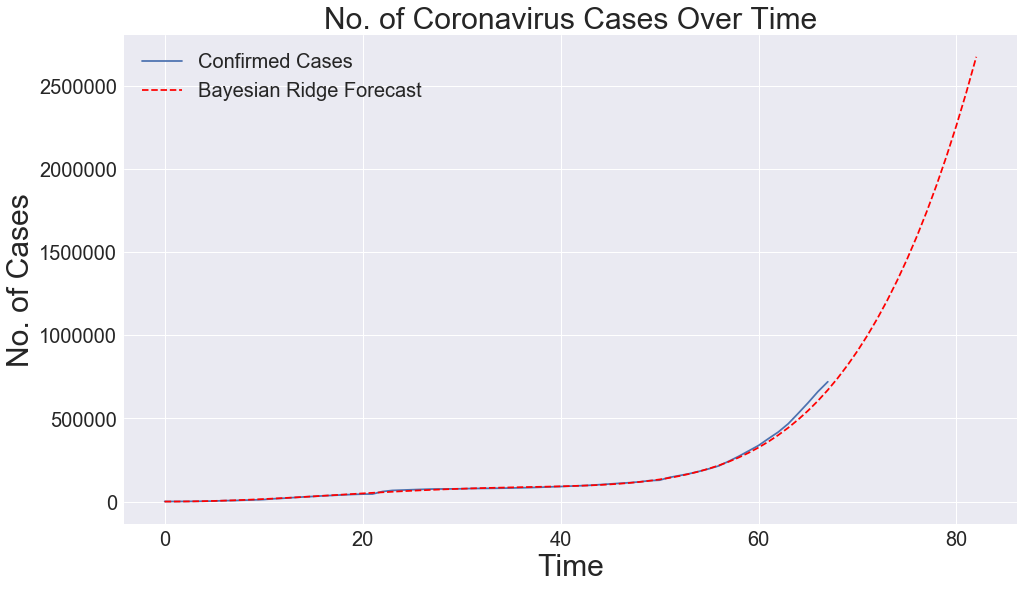

In [137]:
# Bayesian Ridge Forecast Plot
plt.figure(figsize=(16, 9))
plt.plot(alteredDates, global_count)
plt.plot(forecast, bayesFdatesPredict, linestyle='dashed', color='red')
plt.title('No. of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('No. of Cases', size=30)
plt.legend(['Confirmed Cases', 'Bayesian Ridge Forecast'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

**********
Conclusion: In the Training of the algorithms Bayesian Ridge has learned really well according the Test results, therefore, following the forecast of Bayesian Ridge. According to the forecast, the numbers aren't stopping anytime soon and the infected count (tested positive) can go as high as 2672975 in the next 15 days.
**********

**The End**